In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

## Load and preprocess train data

In [2]:
# load data
with open('../witt_preprocessing/pickles/dangjin_merged.pkl','rb') as f:
    dangjin_data = pickle.load(f)
with open('../witt_preprocessing/pickles/ulsan_merged.pkl','rb') as f:
    ulsan_data = pickle.load(f)


# preprocess data for modeling

# time as index
dangjin_data.set_index('time', inplace=True)
ulsan_data.set_index('time', inplace=True)

# dangjin - sum target values
dangjin_data['dangjin_sum'] = dangjin_data['dangjin'] + dangjin_data['dangjin_floating'] + dangjin_data['dangjin_warehouse']
dangjin_data.drop(columns=['dangjin','dangjin_floating','dangjin_warehouse'], inplace=True)

# delete where target == 0
dangjin_data = dangjin_data.loc[dangjin_data['dangjin_sum'] != 0]
ulsan_data =  ulsan_data.loc[ulsan_data['ulsan'] != 0]


'''
# delete rows of night (21시부터 6시)
dangjin_data_full = dangjin_data.copy()
ulsan_data_full = ulsan_data.copy()

dangjin_data['hour'] = dangjin_data.index.hour
def f(x):
    if 5 < x < 21:
        return True
    else:
        return False
dangjin_data = dangjin_data.loc[dangjin_data['hour'].apply(lambda x:f(x))]
dangjin_data.drop(columns=['hour'], inplace=True)
'''

"\n# delete rows of night (21시부터 6시)\ndangjin_data_full = dangjin_data.copy()\nulsan_data_full = ulsan_data.copy()\n\ndangjin_data['hour'] = dangjin_data.index.hour\ndef f(x):\n    if 5 < x < 21:\n        return True\n    else:\n        return False\ndangjin_data = dangjin_data.loc[dangjin_data['hour'].apply(lambda x:f(x))]\ndangjin_data.drop(columns=['hour'], inplace=True)\n"

## Load and preprocess test data (public LB)

In [3]:
sample_submission = pd.read_csv('../original_dataset/sample_submission.csv')

# 2월 일자만
sample_submission_feb = sample_submission.loc[sample_submission['time'].str.contains('2021-02')]
sample_submission_feb

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,0,0,0,0
1,2021-02-01 02:00:00,0,0,0,0
2,2021-02-01 03:00:00,0,0,0,0
3,2021-02-01 04:00:00,0,0,0,0
4,2021-02-01 05:00:00,0,0,0,0
...,...,...,...,...,...
667,2021-02-28 20:00:00,0,0,0,0
668,2021-02-28 21:00:00,0,0,0,0
669,2021-02-28 22:00:00,0,0,0,0
670,2021-02-28 23:00:00,0,0,0,0


In [4]:
# load
with open('../witt_preprocessing/pickles/dangjin_fcst.pkl','rb') as f:
    dangjin = pickle.load(f)
with open('../witt_preprocessing/pickles/ulsan_fcst.pkl','rb') as f:
    ulsan = pickle.load(f)

# index according to sample submission
start, end  = pd.Timestamp('2021-02-01 01:00:00'), pd.Timestamp('2021-03-01-00:00:00') # end == 2021-02-28 24:00:00

# slice test data
dangjin.set_index('time', inplace=True)
dangjin_feb = dangjin.loc[start:end,:]
print(dangjin_feb.shape)

ulsan.set_index('time', inplace=True)
ulsan_feb = ulsan.loc[start:end,:]
print(ulsan_feb.shape)

(672, 9)
(672, 9)


## Config
### X
- obs보다 fcst가 좋다
- Wind_X와 Wind_Y는 제외하는 것이 좋다
- Temperature는 포함하는 것이 좋다
- Year_sin은 포함하는 것이 좋다
### Hp
- min_samples_leaf = 4

In [5]:
# X and Y cols for train data
x_cols_obs = ['Temperature_obs', 'Humidity_obs','Cloud_obs','Day_cos','Day_sin','Year_cos','Year_sin']
x_cols_fcst = ['Temperature_fcst','Humidity_fcst','Cloud_fcst','Day_cos','Day_sin','Year_cos','Year_sin']

y_dangjin_cols = ['dangjin_sum']
y_ulsan_cols = ['ulsan']

RS = 518

## Main prediction

In [6]:
def predict(model, train_data, x_cols_train, y_cols_train, test_data, x_cols_test):
    '''
    train_data, test_data: pd.DataFrame
    '''

    # print
    print('='*50)
    print('x_cols_train: ', x_cols_train)
    print('y_cols_train: ', y_cols_train)
    print('x_cols_test: ', x_cols_test)
    print('='*50)

    # input-target split
    x = train_data.loc[:,x_cols_train]
    y = train_data.loc[:,y_cols_train]

    # fit
    model.fit(x,y)

    # predict
    test_x = test_data.loc[:,x_cols_test]
    predict = model.predict(test_x)

    return predict, model

In [7]:
# X columns for test data
print(dangjin_feb.columns)
print(ulsan_feb.columns)

x_cols_feb = ['Temperature', 'Humidity', 'Cloud','Day_cos', 'Day_sin', 'Year_cos', 'Year_sin']

RS=518

Index(['Temperature', 'Humidity', 'Cloud', 'Wind_X', 'Wind_Y', 'Day_cos',
       'Day_sin', 'Year_cos', 'Year_sin'],
      dtype='object')
Index(['Temperature', 'Humidity', 'Cloud', 'Wind_X', 'Wind_Y', 'Day_cos',
       'Day_sin', 'Year_cos', 'Year_sin'],
      dtype='object')


In [8]:
# predict dangjin
model = RandomForestRegressor(criterion='mae', verbose=0, n_jobs=-1, random_state=RS, n_estimators=100, min_samples_leaf=6)

dangjin_predict, dangjin_model = predict(model, dangjin_data, x_cols_fcst, y_dangjin_cols, dangjin_feb, x_cols_feb)

x_cols_train:  ['Temperature_fcst', 'Humidity_fcst', 'Cloud_fcst', 'Day_cos', 'Day_sin', 'Year_cos', 'Year_sin']
y_cols_train:  ['dangjin_sum']
x_cols_test:  ['Temperature', 'Humidity', 'Cloud', 'Day_cos', 'Day_sin', 'Year_cos', 'Year_sin']
<ipython-input-6-2eca1d0cd7f3>:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x,y)


In [9]:
# predict ulsan
model = RandomForestRegressor(criterion='mae', verbose=0, n_jobs=-1, random_state=RS, n_estimators=100, min_samples_leaf=6)

ulsan_predict, ulsan_model = predict(model, ulsan_data, x_cols_fcst, y_ulsan_cols, ulsan_feb, x_cols_feb)

x_cols_train:  ['Temperature_fcst', 'Humidity_fcst', 'Cloud_fcst', 'Day_cos', 'Day_sin', 'Year_cos', 'Year_sin']
y_cols_train:  ['ulsan']
x_cols_test:  ['Temperature', 'Humidity', 'Cloud', 'Day_cos', 'Day_sin', 'Year_cos', 'Year_sin']
<ipython-input-6-2eca1d0cd7f3>:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x,y)


## Peak prediction

In [175]:
# find peak within day
def argmax_within_day(data): 
    '''
    data should be 1d array
    data should be 24의 배수.
    '''
    peak_arg_list = []

    for i in range(data.shape[0] // 24):
        # sample for 1 day
        sample = data[24*i : 24*i+24]
        # argmax within 1 day
        peak_arg_list.append(sample.argmax() + 24*i)

    return peak_arg_list

In [176]:
# peak in test data (based on prediction of rf)
dangjin_test_arg = argmax_within_day(dangjin_predict)
ulsan_test_arg = argmax_within_day(ulsan_predict)

dangjin_feb_peak = dangjin_feb.iloc[dangjin_test_arg] # test data for peak prediction
ulsan_feb_peak = ulsan_feb.iloc[ulsan_test_arg] # test data for peak prediction

In [177]:
# peak in train data (based on train data)
dangjin_train_arg = argmax_within_day(dangjin_data_full['dangjin_sum'])
ulsan_train_arg = argmax_within_day(ulsan_data_full['ulsan'])

dangjin_data_peak = dangjin_data_full.iloc[dangjin_train_arg] # train data for peak prediction
ulsan_data_peak = ulsan_data_full.iloc[ulsan_train_arg] # train data for peak prediction

In [181]:
RS_PEAK = 521

In [182]:
# new peak prediction (dangjin)
model_peak = RandomForestRegressor(criterion='mae', verbose=0, n_jobs=-1, n_estimators=100, random_state=RS_PEAK, min_samples_leaf=9)

dangjin_predict_peak, dangjin_model_peak = predict(model_peak, dangjin_data_peak, x_cols_fcst, y_dangjin_cols, dangjin_feb_peak, x_cols_feb)

x_cols_train:  ['Temperature_fcst', 'Humidity_fcst', 'Cloud_fcst', 'Day_cos', 'Day_sin', 'Year_cos', 'Year_sin']
y_cols_train:  ['dangjin_sum']
x_cols_test:  ['Temperature', 'Humidity', 'Cloud', 'Day_cos', 'Day_sin', 'Year_cos', 'Year_sin']
<ipython-input-119-2eca1d0cd7f3>:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x,y)


In [183]:
# new peak prediction (ulsan)
model_peak = RandomForestRegressor(criterion='mae', verbose=0, n_jobs=-1, n_estimators=100, random_state=RS_PEAK, min_samples_leaf=9)

ulsan_predict_peak, ulsan_model_peak = predict(model_peak, ulsan_data_peak, x_cols_fcst, y_ulsan_cols, ulsan_feb_peak, x_cols_feb)

x_cols_train:  ['Temperature_fcst', 'Humidity_fcst', 'Cloud_fcst', 'Day_cos', 'Day_sin', 'Year_cos', 'Year_sin']
y_cols_train:  ['ulsan']
x_cols_test:  ['Temperature', 'Humidity', 'Cloud', 'Day_cos', 'Day_sin', 'Year_cos', 'Year_sin']
<ipython-input-119-2eca1d0cd7f3>:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x,y)


Text(0.5, 1.0, 'ulsan')

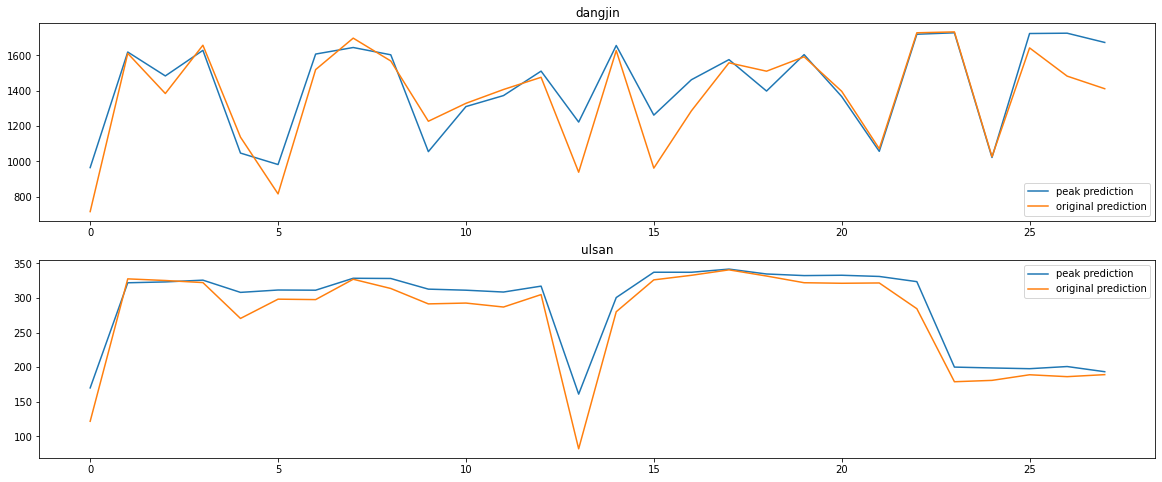

In [184]:
# compare original prediction and peak prediction
fig, ax = plt.subplots(2,1,figsize=(20,8))

ax[0].plot(dangjin_predict_peak, label='peak prediction')
ax[0].plot(dangjin_predict[dangjin_test_arg], label='original prediction')
ax[0].legend()
ax[0].set_title('dangjin')

ax[1].plot(ulsan_predict_peak, label='peak prediction')
ax[1].plot(ulsan_predict[ulsan_test_arg], label='original prediction')
ax[1].legend()
ax[1].set_title('ulsan')

In [185]:
# replace peaks in main prediction with peak prediction

## save org
dangjin_predict_ = dangjin_predict.copy()
ulsan_predict_ = ulsan_predict.copy()

## replace
dangjin_predict[dangjin_test_arg] = dangjin_predict_peak
ulsan_predict[ulsan_test_arg] = ulsan_predict_peak

## sample_submission.csv

In [10]:
def to_submission(dangjin_predict, ulsan_predict):
    # sum (doesn't matter)
    predict = dangjin_predict + ulsan_predict
    # add
    sample_submission.iloc[:predict.shape[0],1] = predict

    return sample_submission

In [11]:
def below_320(df):
    # function to apply
    def f(x):
        if x<320:
            return 320
        else:
            return x
    df['dangjin_floating'] = df['dangjin_floating'].apply(lambda x:f(x))
    return df

In [12]:
# below_320
submission_org = to_submission(dangjin_predict, ulsan_predict)
submission_320 = below_320(submission_org)

# to csv
PATH = 'rf_min-leaf-4_no-zero_itp-quad_320_.csv'
submission_320.to_csv(PATH, index=False)

# check
pd.read_csv(PATH)

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,320.0,0,0,0
1,2021-02-01 02:00:00,320.0,0,0,0
2,2021-02-01 03:00:00,320.0,0,0,0
3,2021-02-01 04:00:00,320.0,0,0,0
4,2021-02-01 05:00:00,320.0,0,0,0
...,...,...,...,...,...
1387,2021-07-08 20:00:00,320.0,0,0,0
1388,2021-07-08 21:00:00,320.0,0,0,0
1389,2021-07-08 22:00:00,320.0,0,0,0
1390,2021-07-08 23:00:00,320.0,0,0,0


## Playing with already-submitted data

In [15]:
k = pd.read_csv('rf_min-leaf-4_no-zero_itp-quad_320_.csv')

In [16]:
def add_value(df):
    # function to apply
    def f(x):
        if x>320:
            return x+20
        else:
            return x
    df['dangjin_floating'] = df['dangjin_floating'].apply(lambda x:f(x))
    return df

add_value(k).to_csv('rf_min-leaf-4_no-zero_itp-quad_320_add20.csv',index=False)
# add 20: 8.4 -> 8.01
# add 30: 8.4 -> 8.09

In [30]:
# peaktime add 20
# peaktime: 12~15시
ADD = 20

for i in range(k.shape[0]):
    if i%24 in [11,12,13,14]: # index 0 corresponds to 01:00:00
        k.loc[i,'dangjin_floating'] += ADD

# add tp 20: 8.4 -> 8.27

In [35]:
k.to_csv('submissions/rf_min-leaf-4_320_addpt20.csv',index=False)